In [1]:
!pip install vaderSentiment

In [2]:
import csv
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pandas as pd
import os.path

data_sufix = 'data/'

In [3]:
# configure Session class with desired options
Session = sessionmaker()
engine = create_engine('sqlite:///twitter.db')

In [17]:
engine.table_names()

['hashtag', 'retweet', 'tweet', 'user']

In [18]:
#VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

allTweets = pd.read_sql_query('SELECT tweet_id as id, tweet_text as text FROM tweet', engine)
print(allTweets.shape)

(17220, 2)


In [19]:
allRetweets =  pd.read_sql_query('SELECT retweet_id as id, retweet_text as text FROM retweet', engine)
print(allRetweets.shape)

(77828, 2)


In [52]:
vaderData = allTweets.append([allRetweets])
vaderData.drop_duplicates(inplace=True)
# vaderData = vaderData[:60000]
# vaderData

In [53]:
vaderIDs = pd.read_sql_query('SELECT id FROM vader', engine)
solo = vaderIDs.drop_duplicates()
print(solo.shape)
vaderIDs.shape

(91265, 1)


(91267, 1)

In [54]:
newVaders = pd.DataFrame(columns=['id', 'negative','neutral','positive','compound'])

In [55]:
for index, row in vaderData.iterrows():
     if(not vaderIDs['id'].isin([row['id']]).any()):
        snt = analyser.polarity_scores(row['text'])
        newVaders = newVaders.append({'id': row['id'],
                                     'negative': snt['neg'],
                                     'neutral': snt['neu'],
                                     'positive': snt['pos'],
                                     'compound': snt['compound']}, ignore_index=True)
newVaders

,id,negative,neutral,positive,compound


In [50]:
newVaders.to_sql('vader', engine, if_exists='append')

In [39]:
# from sqlalchemy import MetaData, Table
# meta = MetaData()
# vader_tab = Table('vader', meta)
# vader_tab.drop(engine)

In [56]:
#Analyse
analyse_df = pd.read_sql_query('SELECT * FROM vader', engine)
analyse_df.shape

(91267, 6)

In [66]:
round(0.6,2) * 50 + 50

80.0

In [68]:
for index, row in analyse_df.iterrows():
    final_score = round(row["compound"],2) * 50 + 50
    analyse_df.at[index,'percent'] = final_score
    if(final_score<34):
        analyse_df.at[index,'mood'] = "Bad"
    elif(final_score<67):
        analyse_df.at[index,'mood'] = "Neutral"
    else:
        analyse_df.at[index,'mood'] = "Good"

In [71]:
%matplotlib inline

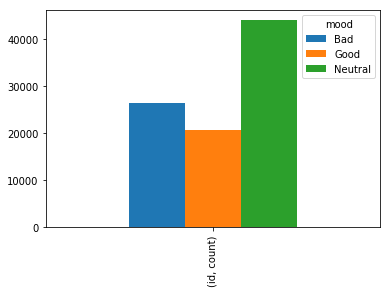

In [90]:
figure = analyse_df[['id', 'mood']].groupby(['mood']).agg(['count']).T
figure.plot.bar()

In [ ]:
# associate it with our custom Session class
Session.configure(bind=engine)